In [51]:
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.regime_switching.markov_autoregression import MarkovAutoregression

# Import des données

In [55]:
df = pd.read_csv("./data/GNP.csv")

In [56]:
df["GR_GNP"] = np.log(df['GNP']).diff()*100
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.iloc[1:]

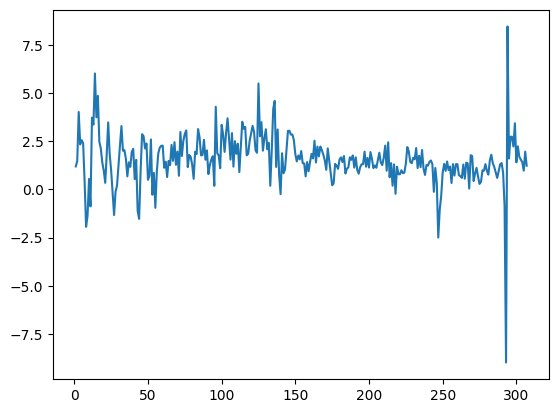

In [57]:
plt.plot(df["GR_GNP"])

# Visualisations des crises

In [42]:
usrec = DataReader("USREC", 
                   "fred", 
                   start=datetime(1947, 1, 1), 
                   end=datetime(2023, 10, 1))

usrec.index = pd.to_datetime(usrec.index)

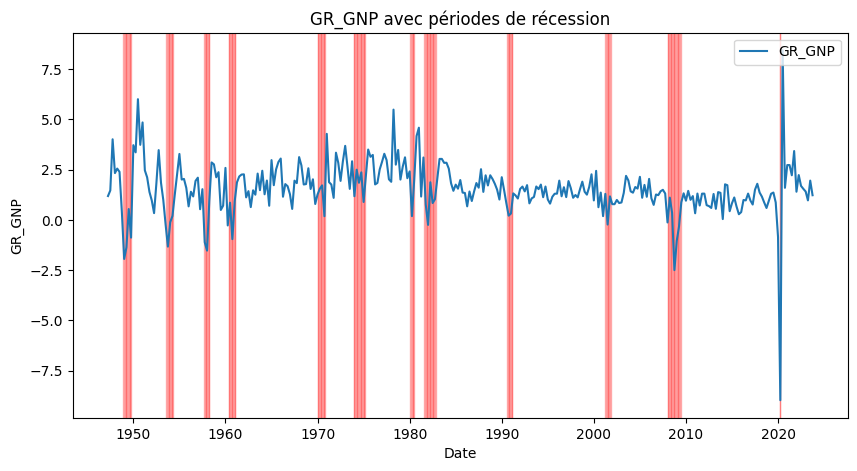

In [45]:
plt.figure(figsize=(10, 5))
plt.plot(df.DATE, df["GR_GNP"], label='GR_GNP')

for period in usrec.loc[usrec['USREC'] == 1].index.to_series().groupby((usrec['USREC'] == 1).cumsum()).agg(['first','last']).itertuples():
    plt.axvspan(period.first, period.last, color='red', alpha=0.3)

plt.title("GR_GNP avec périodes de récession")
plt.xlabel("Date")
plt.ylabel("GR_GNP")
plt.legend()
plt.show()

# Modélisation - Modèle AutoRegression

In [82]:
mar_model = MarkovAutoregression(df['GR_GNP'], k_regimes=2, order=2, switching_ar=False, switching_variance=True)
mar_res = mar_model.fit()

In [83]:
print(mar_res.summary())

                         Markov Switching Model Results                         
Dep. Variable:                   GR_GNP   No. Observations:                  305
Model:             MarkovAutoregression   Log Likelihood                -393.897
Date:                  Sat, 27 Apr 2024   AIC                            803.795
Time:                          17:38:10   BIC                            833.557
Sample:                               0   HQIC                           815.699
                                  - 305                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5706      0.093     16.821      0.000       1.388       1.754
sigma2         0.3706      0.047    

In [85]:
df2 = df.iloc[2:, :]

In [86]:
df2

,DATE,GNP,GR_GNP
3,1947-10-01,260.981,4.012678
4,1948-01-01,267.133,2.329905
5,1948-04-01,274.046,2.554931
6,1948-07-01,280.679,2.391569
7,1948-10-01,281.837,0.411722
...,...,...,...
303,2022-10-01,26593.998,1.546472
304,2023-01-01,26972.528,1.413332
305,2023-04-01,27236.100,0.972443
306,2023-07-01,27774.189,1.956384


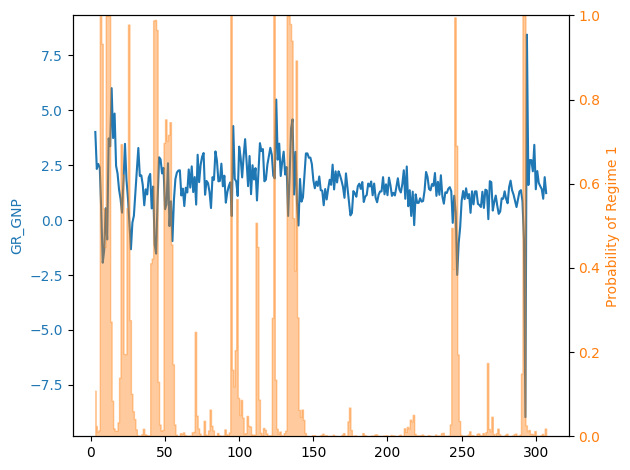

In [94]:
smoothed_marginal_probabilities = mar_res.smoothed_marginal_probabilities

# Plot the series and the smoothed probabilities
fig, ax1 = plt.subplots()

ax1.plot(df2.index, df2['GR_GNP'], label='GR_GNP')
ax1.set_ylabel('GR_GNP', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')

ax2 = ax1.twinx()
ax2.fill_between(df2.index, smoothed_marginal_probabilities[1], step='pre', alpha=0.4, color='C1')
ax2.set_ylabel('Probability of Regime 1', color='C1')
ax2.tick_params(axis='y', labelcolor='C1')
ax2.set_ylim([0, 1])

fig.tight_layout()
plt.show()

In [91]:
import numpy as np

p00, p10, const0, const1, sigma0, sigma1, ar1_L1, ar1_L2 = mar_res.params
log_odds = np.array([const0, const1])
diff_log_odds = np.array([log_odds[i] - log_odds[j] for i in range(len(log_odds)) for j in range(len(log_odds))])

transition_probs = np.exp(diff_log_odds) / (1 + np.exp(diff_log_odds))

transition_matrix = np.array([transition_probs[i:i+len(log_odds)] for i in range(0, len(transition_probs), len(log_odds))])

transition_matrix /= np.sum(transition_matrix, axis=1)[:,None]

transition_matrix

array([[0.38871725, 0.61128275],
       [0.2994432 , 0.7005568 ]])

On a 38% de chance de rester en régime 0 si on est en régime 0, 61% de passer en régime 1. On a 29% de chance de passze en régime 0 si on est en régime 1, 70% de rester en régime 1. 

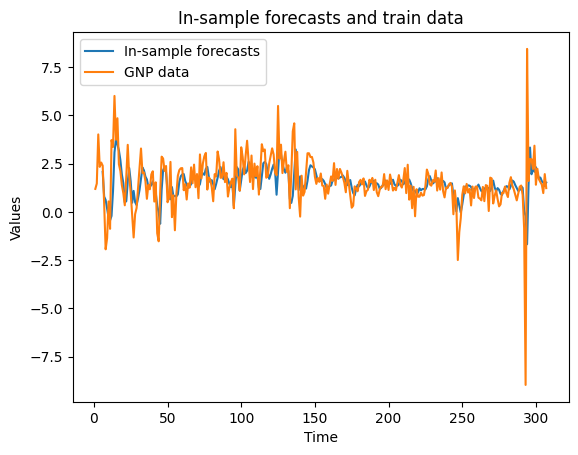

In [92]:
in_sample_forecasts = mar_res.predict()

# Plot the data
plt.plot(in_sample_forecasts, label='In-sample forecasts')
plt.plot(df['GR_GNP'], label='GNP data')

# Add axis labels and title
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('In-sample forecasts and train data')

# Add legend
plt.legend()

# Show the plot
plt.show()

# Modélisation - Modèle Regression

In [96]:
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

model2 = MarkovRegression(df['GR_GNP'], k_regimes=2, trend='c', switching_variance=True)
model2fitted = model2.fit()

In [97]:
print(model2fitted.summary())

                        Markov Switching Model Results                        
Dep. Variable:                 GR_GNP   No. Observations:                  307
Model:               MarkovRegression   Log Likelihood                -435.821
Date:                Sat, 27 Apr 2024   AIC                            883.642
Time:                        18:33:06   BIC                            906.003
Sample:                             0   HQIC                           892.584
                                - 307                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3332      0.045     29.680      0.000       1.245       1.421
sigma2         0.2756      0.035      7.914      0.0

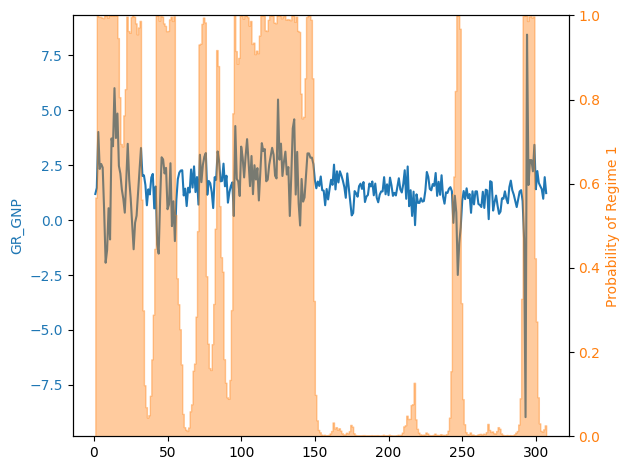

In [99]:
smoothed_marginal_probabilities = model2fitted.smoothed_marginal_probabilities

# Plot the series and the smoothed probabilities
fig, ax1 = plt.subplots()

ax1.plot(df.index, df['GR_GNP'], label='GR_GNP')
ax1.set_ylabel('GR_GNP', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')

ax2 = ax1.twinx()
ax2.fill_between(df.index, smoothed_marginal_probabilities[1], step='pre', alpha=0.4, color='C1')
ax2.set_ylabel('Probability of Regime 1', color='C1')
ax2.tick_params(axis='y', labelcolor='C1')
ax2.set_ylim([0, 1])

fig.tight_layout()
plt.show()

In [100]:
import numpy as np

p00, p10, const0, const1, sigma0, sigma1 = model2fitted.params
log_odds = np.array([const0, const1])
diff_log_odds = np.array([log_odds[i] - log_odds[j] for i in range(len(log_odds)) for j in range(len(log_odds))])

transition_probs = np.exp(diff_log_odds) / (1 + np.exp(diff_log_odds))

transition_matrix = np.array([transition_probs[i:i+len(log_odds)] for i in range(0, len(transition_probs), len(log_odds))])

transition_matrix /= np.sum(transition_matrix, axis=1)[:,None]

transition_matrix

array([[0.57152192, 0.42847808],
       [0.55561201, 0.44438799]])

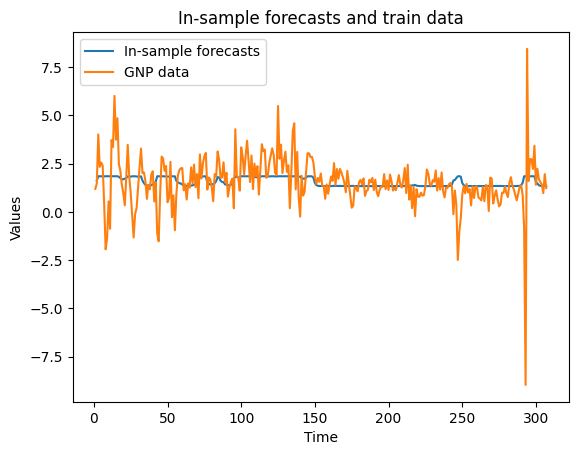

In [101]:
in_sample_forecasts = model2fitted.predict()

# Plot the data
plt.plot(in_sample_forecasts, label='In-sample forecasts')
plt.plot(df['GR_GNP'], label='GNP data')

# Add axis labels and title
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('In-sample forecasts and train data')

# Add legend
plt.legend()

# Show the plot
plt.show()